In [138]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist.floating_axes import GridHelperCurveLinear, FloatingSubplot
import mpl_toolkits.axisartist.grid_finder as gf

from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import healpy as hp
from fpipe.map import algebra as al

In [180]:
def generate_polar_axes(figure=None, figsize=None, tf2=None, gl2=None, fmin=None, fmax=None, radius_min = 0.8, radius_max = 1):
    polar_trans = PolarAxes.PolarTransform()

    # Setup the axis, here we map angles in degrees to angles in radius
    phi_degree = np.arange(60, 121, 15)
    tlocs = phi_degree * np.pi / 180
    gl1 = gf.FixedLocator(tlocs)  # Positions
    
    #ra_list = np.array([9, 10, 11, 12, 13])
    #tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, ra_list))))
    ra_list = np.array(['%02dh'%x for x in [9, 10, 11, 12, 13]])
    tf1 = gf.DictFormatter(dict(zip(tlocs, ra_list)))
    


    # Standard deviation axis extent
    if tf2 is None:
        flocs = np.linspace(radius_min, radius_max, 5)
        gl2 = gf.FixedLocator(flocs)
        if fmin is None: fmin=1.05
        if fmax is None: fmax=1.15
        f_list = np.array(['%d'%x for x in np.linspace(fmin, fmax, 5)])
        tf2 = gf.DictFormatter(dict(zip(flocs, f_list)))

    # Set up the axes range in the parameter "extremes"
    ghelper = GridHelperCurveLinear(polar_trans, 
                                    extremes=(tlocs.min(), tlocs.max(),  # 1st quadrant
                                              radius_min, radius_max),
                                    grid_locator1=gl1,
                                    tick_formatter1=tf1,
                                    grid_locator2=gl2,
                                    tick_formatter2=tf2
                                    )

    if figure is None:
        figure = plt.figure(figsize=figsize)

    floating_ax = FloatingSubplot(figure, 111, grid_helper=ghelper)
    figure.add_subplot(floating_ax)

    # Adjust axes
    floating_ax.axis["top"].set_axis_direction("bottom")  # "Angle axis"
    floating_ax.axis["top"].toggle(ticklabels=True, label=True)
    floating_ax.axis["top"].major_ticks.set_tick_out(True)
    floating_ax.axis["top"].major_ticklabels.set_axis_direction("top")
    floating_ax.axis["top"].label.set_axis_direction("top")
    #floating_ax.axis["top"].label.set_text("angle (deg)")

    floating_ax.axis["left"].set_axis_direction("bottom")  # "X axis"
    floating_ax.axis["left"].major_ticks.set_tick_out(True)
    floating_ax.axis["left"].major_ticklabels.set_axis_direction("right")
    floating_ax.axis["left"].label.set_text("Frequency [MHz]")
    floating_ax.axis["left"].toggle(ticklabels=True)

    floating_ax.axis["right"].set_axis_direction("top")  # "Y axis"
    floating_ax.axis["right"].major_ticks.set_tick_out(True)
    #floating_ax.axis["right"].major_ticklabels.set_axis_direction("left")
    #floating_ax.axis["right"].label.set_text("Frequency")
    floating_ax.axis["right"].toggle(ticklabels=False)
    #
    
    floating_ax.axis['bottom'].toggle(ticklabels=False)

    #floating_ax.axis["bottom"].set_visible(False)  # Useless

    # Contours along standard deviations
    #floating_ax.grid(True)
    #floating_ax.set_title("Quarter polar plot")

    data_ax = floating_ax.get_aux_axes(polar_trans)  # return the axes that can be plotted on

    return figure, data_ax

In [172]:
data_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'
data_name = 'Combined_1050-1150MHz.h5'


with h5.File(data_path + data_name, 'r') as f:
    clean_map = al.load_h5(f, 'clean_map')
    clean_map_l = al.make_vect(clean_map, axis_names=clean_map.info['axes'])
    
    nside = f['nside'][()]
    map_pix_l = f['map_pix'][:]
    freq_edges_l = clean_map_l.get_axis_edges('freq')
    
    
data_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'
data_name = 'Combined_1250-1450MHz.h5'


with h5.File(data_path + data_name, 'r') as f:
    clean_map = al.load_h5(f, 'clean_map')
    clean_map_h = al.make_vect(clean_map, axis_names=clean_map.info['axes'])

    nside = f['nside'][()]
    map_pix_h = f['map_pix'][:]
    freq_edges_h = clean_map_h.get_axis_edges('freq')

In [173]:
ra_edges = np.linspace(9*15, 13*15, 2001)
ra, dec = hp.pix2ang(nside, map_pix, lonlat=True)

ra_map_l  = np.zeros((clean_map_l.shape[0], ra_edges.shape[0]-1))
for i in range(ra_map_l.shape[0]):
    mask = clean_map_l[i] == 0
    norm = np.histogram(ra[~mask], bins=ra_edges)[0] * 1.
    norm[ norm==0 ] = np.inf
    ra_map_l[i]  = np.histogram(ra[~mask], bins=ra_edges, weights=clean_map_l[i][~mask])[0] / norm
    
ra_map_h  = np.zeros((clean_map_h.shape[0], ra_edges.shape[0]-1))
for i in range(ra_map_h.shape[0]):
    mask = clean_map_h[i] == 0
    norm = np.histogram(ra[~mask], bins=ra_edges)[0] * 1.
    norm[ norm==0 ] = np.inf
    ra_map_h[i]  = np.histogram(ra[~mask], bins=ra_edges, weights=clean_map_h[i][~mask])[0] / norm

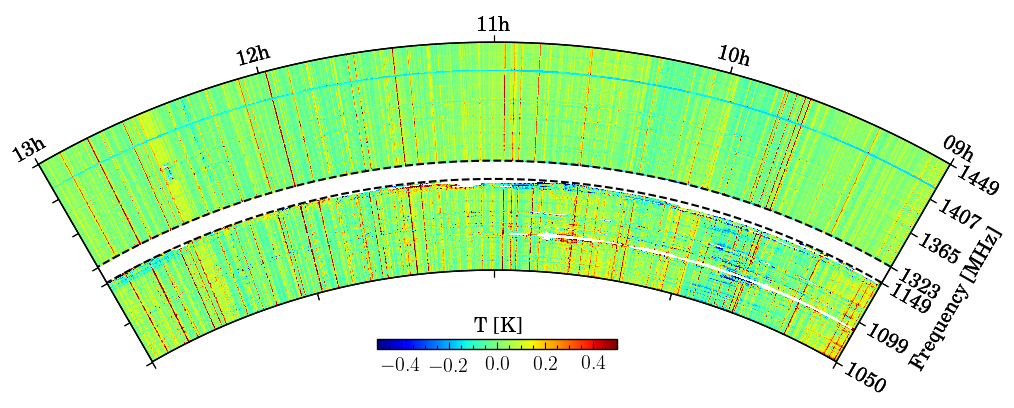

In [200]:
# Plot data onto the defined polar axes
figsize = (12, 5)
fig = None

radius_min=0.75
radius_max=1

flocs = np.concatenate( [np.linspace(radius_min, 0.85, 3), np.linspace(0.87, radius_max, 4)] ) 
gl2 = gf.FixedLocator(flocs)
f_list = ['%d'%x for x in np.linspace(freq_edges_l.min(), freq_edges_l.max(), 3)]\
       + ['%d'%x for x in np.linspace(freq_edges_h.min(), freq_edges_h.max(), 4)]
tf2 = gf.DictFormatter(dict(zip(flocs, f_list)))

fig, ax = generate_polar_axes(fig, figsize, tf2=tf2, gl2=gl2, radius_min = radius_min, radius_max = radius_max)


ra_map_l = np.ma.masked_equal(ra_map_l, 0)
xx = np.linspace(60, 120, ra_edges.shape[0]) * np.pi / 180.
yy = np.linspace(0.75, 0.85, freq_edges_l.shape[0])
ax.plot(xx, 0.85*np.ones_like(xx), 'k--', lw=1.5, zorder=1000)
yy, xx = np.meshgrid(yy, xx)
im = ax.pcolormesh(xx, yy, ra_map_l.T, vmin=-0.5, vmax=0.5)



ra_map_h = np.ma.masked_equal(ra_map_h, 0)
xx = np.linspace(60, 120, ra_edges.shape[0]) * np.pi / 180.
yy = np.linspace(0.87, 1, freq_edges_h.shape[0])
ax.plot(xx, 0.87*np.ones_like(xx), 'k--', lw=1.5, zorder=1000)
yy, xx = np.meshgrid(yy, xx)
im = ax.pcolormesh(xx, yy, ra_map_h.T, vmin=-0.5, vmax=0.5)

cax = fig.add_axes([0.415, 0.2, 0.2, 0.02])
cax.set_title('T [K]')
fig.colorbar(im, ax=ax, cax=cax, orientation="horizontal")


fig.savefig("output/map_ra_freq.png", dpi=200)